# Autoenconders

In this notebook, we build simple convolutional autoencoders to learn compressed representations of MNIST digits and reconstruct them back.

We train one model for image denoising, where the network receives noisy digits and learns to reconstruct clean versions. We also train two models for super-resolution, taking low-resolution inputs (7×7 and 14×14) and generating 28×28 outputs that look close to the original images.

## Imports

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [46]:
# Device selection to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data loading


We use the MNIST digits dataset and load it. Each image is converted to a tensor in the range [0,1], and we create separate data loaders for training and validation with a batch size of 64. A quick check of torch.min and torch.max on a batch confirms that the pixel are between 0 and 1.

In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)  

In [48]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## Utility functions


We define two helper functions used in the experiments. `add_gaussian_noise` corrupts input images with Gaussian noise, which is needed for the denoising task. `downsample_images` resizes images to a lower resolution (7×7 or 14×14), and will be used later for the super‑resolution autoencoders.

In [49]:
def add_gaussian_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * torch.randn_like(images)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

def downsample_images(images, target_size):
    return F.interpolate(images, size=(target_size, target_size), mode='bicubic')

## Autoencoders Model

### Linear Autoencoder

As a first step, we define a simple fully connected autoencoder that works on flattened MNIST images (28×28 → 784 values).

The encoder progressively reduces the dimensionality from 784 down to a 3‑dimensional latent vector, and the decoder mirrors this structure to reconstruct the original 784‑dimensional image. 

In [50]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Denoising Autoencoder

This autoencoder uses convolutions that operates directly on 28x28 MNIST images.

The encoder uses strided convolutions to gradually reduce the spatial resolution from 28×28 to a 1×1 feature map with 64 channels, which acts as the bottleneck (latent space). The decoder then applies transposed convolutions to expand this 1×1×64 representation back to a 1×28×28 image, learning to reconstruct the original digit from its compressed latent code.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Training the Denoising Autoencoder


For each batch, Gaussian noise is added to the input images and the model is optimized to reconstruct the original clean images from their noisy versions using MSE loss and the Adam optimizer.

In [90]:
model_denoising = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer_dn = torch.optim.Adam(model_denoising.parameters(), lr=1e-3, weight_decay=1e-5)

In [91]:
num_epochs = 10
noise_factor = 0.5
outputs_denoising = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        noisy_img = add_gaussian_noise(img, noise_factor)
        
        recon = model_denoising(noisy_img)
        loss = criterion(recon, img)
        
        optimizer_dn.zero_grad()
        loss.backward()
        optimizer_dn.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_denoising.append((epoch, img.detach().cpu(), noisy_img.detach().cpu(), recon.detach().cpu()))


Epoch:1, Loss:0.0160
Epoch:2, Loss:0.0143
Epoch:3, Loss:0.0121
Epoch:4, Loss:0.0124
Epoch:5, Loss:0.0114
Epoch:6, Loss:0.0111
Epoch:7, Loss:0.0106
Epoch:8, Loss:0.0104
Epoch:9, Loss:0.0120
Epoch:10, Loss:0.0108


#### Denoising results on training data

The following figure shows the output of the denoising autoencoder on a batch from the training set.  

The first row contains the original clean MNIST digits, the second row their corrupted versions with added Gaussian noise, and the third row the corresponding reconstructions produced after training.

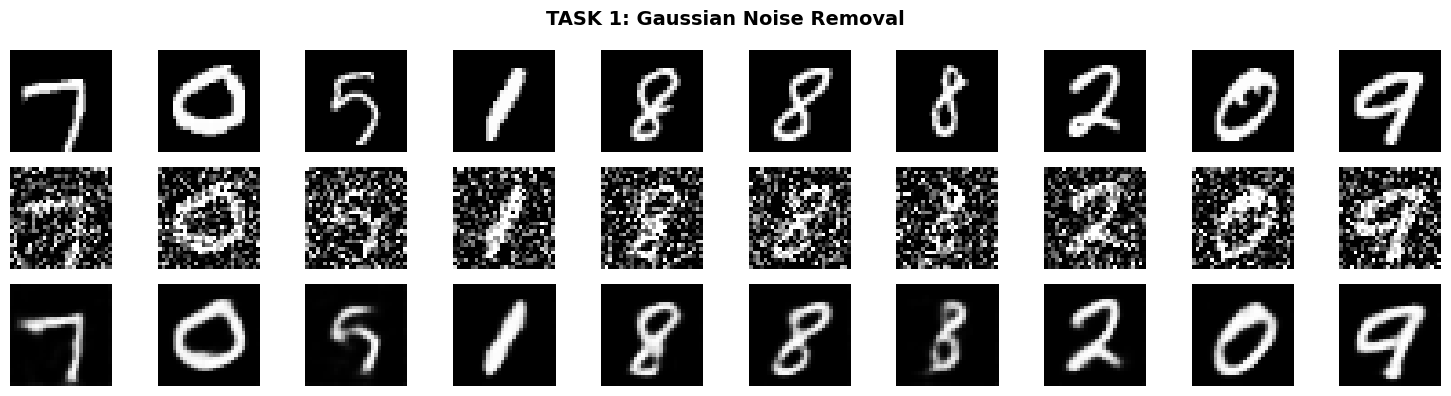

In [73]:
epoch, original, noisy, reconstructed = outputs_denoising[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TASK 1: Gaussian Noise Removal', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(noisy[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(reconstructed[i].squeeze())
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Denoising results on validation data

To evaluate the generalization ability of the model, we apply the trained denoising autoencoder to images from the validation set.

Again, the first row shows the original validation images, the second row the noisy inputs, and the third row the reconstructed outputs obtained without gradient computation in evaluation mode.

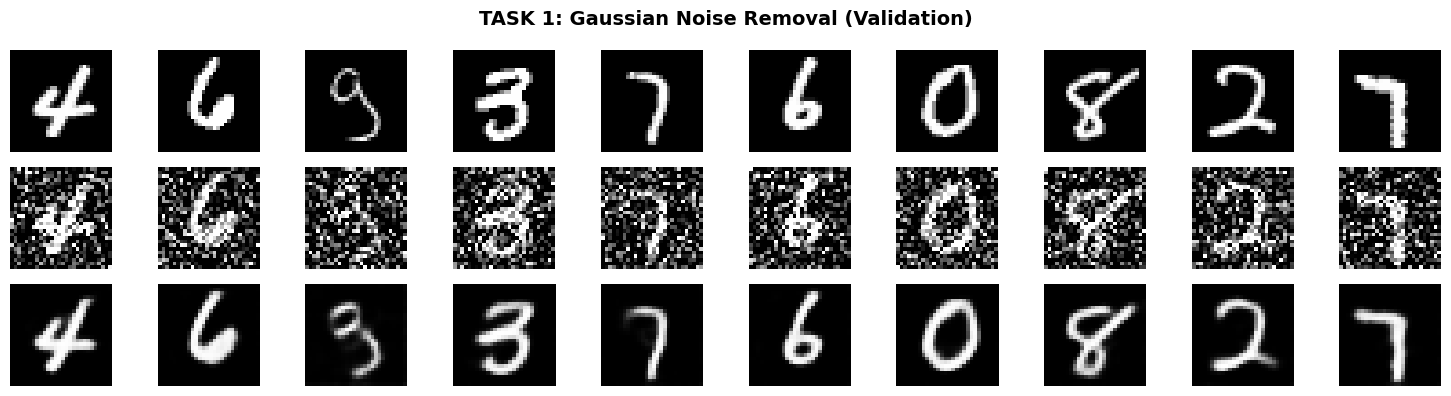

In [ ]:
model_denoising.eval()

num_images = 10
dataiter = iter(data_loader_valid)
images, _ = next(dataiter)

images = images.to(device)

with torch.no_grad():
    noisy_images = add_gaussian_noise(images, noise_factor)
    reconstructed = model_denoising(noisy_images)

images_cpu = images.cpu()
noisy_cpu = noisy_images.cpu()
recon_cpu = reconstructed.cpu()

plt.figure(figsize=(15, 4))
plt.suptitle('TASK 1: Gaussian Noise Removal (Validation)', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(images_cpu[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(noisy_cpu[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(recon_cpu[i].squeeze())
    plt.axis('off')

plt.tight_layout()
plt.show()


### SuperResolution 7×7 autoencoder

This section defines the convolutional autoencoder used for the 7×7 → 28×28 super‑resolution task. The encoder applies two convolutional layers with Batch Normalization and ReLU activations to extract a latent representation from low‑resolution 7×7 inputs. The decoder then uses transposed convolutions to progressively upsample these features and reconstruct a 28×28 image.

In [ ]:
class SuperResolution7x7(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


#### Training the convolutional denoising autoencoder

For each batch, the images are downsampled to 7x7 to the input images and the model is optimized to reconstruct the original clean images from their noisy versions using MSE loss and the Adam optimizer.

In [86]:
model_sr7 = SuperResolution7x7().to(device)
criterion = nn.MSELoss()
optimizer_sr7 = torch.optim.Adam(model_sr7.parameters(), lr=1e-3, weight_decay=1e-5)

In [87]:
num_epochs = 15
outputs_sr7 = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        img_7x7 = downsample_images(img, 7)
        
        recon = model_sr7(img_7x7)
        loss = criterion(recon, img)
        
        optimizer_sr7.zero_grad()
        loss.backward()
        optimizer_sr7.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_sr7.append((epoch, img.detach().cpu(), img_7x7.detach().cpu(), recon.detach().cpu()))


Epoch:1, Loss:0.0196
Epoch:2, Loss:0.0153
Epoch:3, Loss:0.0162
Epoch:4, Loss:0.0145
Epoch:5, Loss:0.0153
Epoch:6, Loss:0.0149
Epoch:7, Loss:0.0122
Epoch:8, Loss:0.0127
Epoch:9, Loss:0.0126
Epoch:10, Loss:0.0127
Epoch:11, Loss:0.0133
Epoch:12, Loss:0.0129
Epoch:13, Loss:0.0124
Epoch:14, Loss:0.0113
Epoch:15, Loss:0.0110


#### Super-resolution results on training data

The following figure shows the output of the 7×7 → 28×28 super‑resolution autoencoder on a batch from the training set.  

The first row contains the original clean MNIST digits, the second row their low‑resolution versions downsampled to 7×7, and the third row the corresponding high‑resolution reconstructions produced by the autoencoder after training.

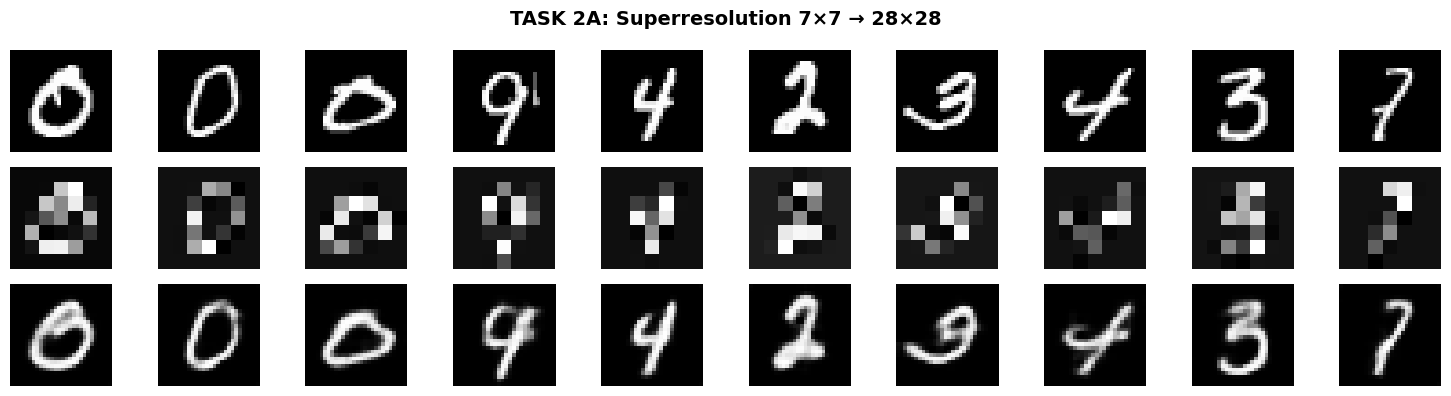

In [92]:
epoch, original, low_res, reconstructed = outputs_sr7[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TASK 2A: Superresolution 7×7 → 28×28', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(low_res[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(reconstructed[i].squeeze())
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Super-resolution results on validation data

To evaluate the generalization ability of the model, the trained super-resolution autoencoder is applied to images from the validation set.

The first row contains the original high‑resolution validation digits, the second row their low‑resolution 7×7 versions, and the third row the reconstructed 28×28 outputs obtained in evaluation mode without gradient computation.

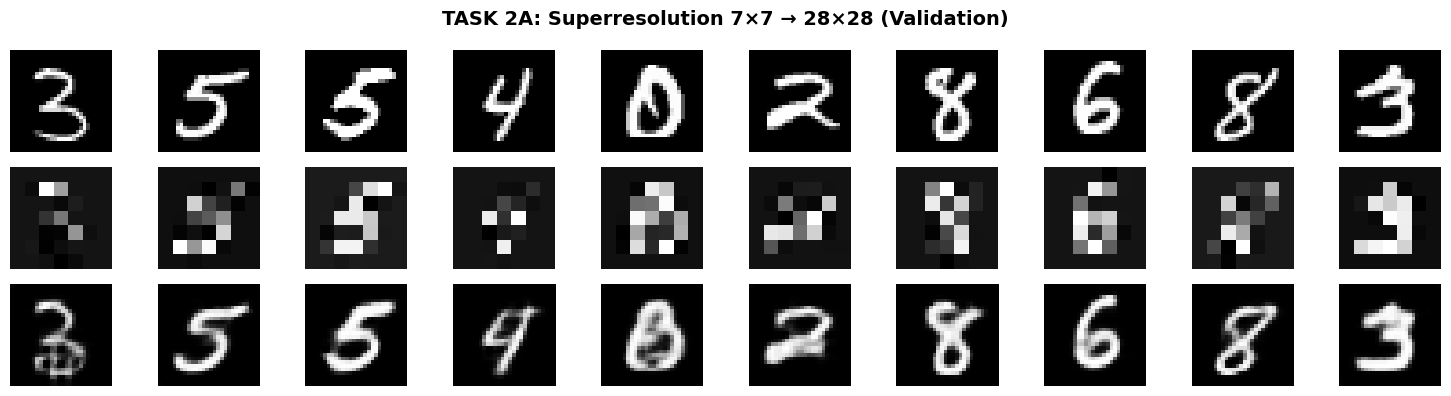

In [94]:
model_sr7.eval()

num_images = 10
dataiter = iter(data_loader_valid)
images, _ = next(dataiter)

images = images.to(device)

with torch.no_grad():
    low_res_images = downsample_images(images, 7)
    reconstructed = model_sr7(low_res_images)

images_cpu = images.cpu()
low_res_cpu = low_res_images.cpu()
recon_cpu = reconstructed.cpu()

plt.figure(figsize=(15, 4))
plt.suptitle('TASK 2A: Superresolution 7×7 → 28×28 (Validation)', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(images_cpu[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(low_res_cpu[i].squeeze())
    plt.axis('off')

    plt.subplot(3, num_images, 2 * num_images + i + 1)
    plt.imshow(recon_cpu[i].squeeze())
    plt.axis('off')

plt.tight_layout()
plt.show()

### SuperResolution 14x14

In [ ]:
class SuperResolution14x14(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model_sr14 = SuperResolution14x14()
optimizer_sr14 = torch.optim.Adam(model_sr14.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 15
outputs_sr14 = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img_14x14 = downsample_images(img, 14)
        
        recon = model_sr14(img_14x14)
        loss = criterion(recon, img)
        
        optimizer_sr14.zero_grad()
        loss.backward()
        optimizer_sr14.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_sr14.append((epoch, img, img_14x14, recon))


Epoch:1, Loss:0.0022
Epoch:2, Loss:0.0021
Epoch:3, Loss:0.0016
Epoch:4, Loss:0.0021
Epoch:5, Loss:0.0016
Epoch:6, Loss:0.0018
Epoch:7, Loss:0.0017
Epoch:8, Loss:0.0015
Epoch:9, Loss:0.0017
Epoch:10, Loss:0.0015
Epoch:11, Loss:0.0013
Epoch:12, Loss:0.0017
Epoch:13, Loss:0.0014
Epoch:14, Loss:0.0013
Epoch:15, Loss:0.0013


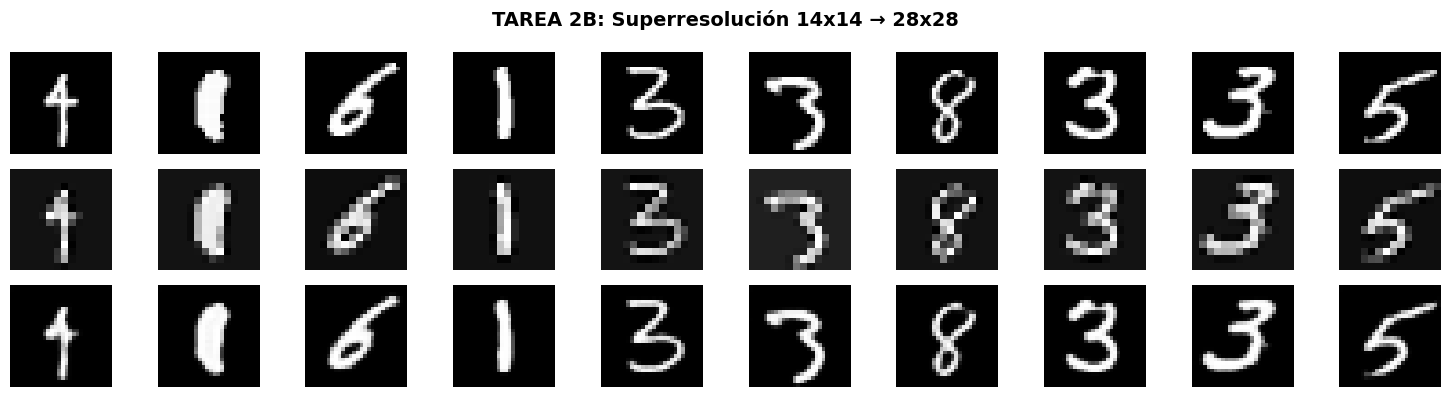

In [ ]:
epoch, original, low_res, reconstructed = outputs_sr14[-1]
num_images = 10

plt.figure(figsize=(15, 4))
plt.suptitle('TAREA 2B: Superresolución 14x14 → 28x28', fontsize=14, fontweight='bold')
plt.gray()

for i in range(num_images):
    plt.subplot(3, num_images, i+1)
    plt.imshow(original[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Original\n(28x28)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(low_res[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Reducida\n(14x14)', fontsize=11, fontweight='bold')
    
    plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(reconstructed[i].detach().squeeze())
    plt.axis('off')
    if i == 0:
        plt.ylabel('Generada\n(28x28)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
